In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import bisect
sys.path.append('D:/Dropbox/py_projects/customlib/')
import customlib as cl

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
energy = 25e-3
waist = 20e-6
wavelength = 1030e-9
pulselength = 1.25e-12

cl.laser.zrayleigh(waist, wavelength)
cl.laser.waist(waist, 380e-3, wavelength, 1.15)

print(cl.laser.efld(waist, energy/pulselength) * 1e-10)
print(cl.laser.fluence(waist, energy))

print(cl.laser.a0potential(cl.laser.efld(waist, energy/pulselength), wavelength))

9.20837184557166
1989.436788648692
0.02954066019066828


In [29]:
print(cl.laser.photon_energy(wavelength) / pc.elementary_charge ) 
print(pc.elementary_charge)

1.2037300818757306
1.602176634e-19


0.08920620580763855

# import data
---


## temperature

In [3]:



def load_temperature_data(tempspath, mode='thermometers', datetime='20210803'):
    """
    It is expected that there are 2 csv files (1 for each thermometer). 

    tempspath - path to the file(s) to be imported
    mode = {'thermometers','thermocouples'} this setting affects how the CSV document is parsed.
        'thermometers' is the current way of measuring and recording the temperature in the room (2 govee thermometers)
            thermometer 1 is usually placed on top of the front-end box
            thermometer 2 is usually placed on top of the laser table 
        'thermocouples' in this mode 3 thermocouples were brought in and data was recorded on the control room's control system.
    datetime='20210803', used to import only files of a specific date. It is a str of the form 'yyyymmdd' or 'yyyymmddhhmm' or any substring e.g. 'ymmd'

    """

    if mode == 'thermometers':
        
        fnlist = []
        fnlisttemp = os.listdir(tempspath)
        fnlisttemp = [ tempspath+fn for fn in fnlisttemp if (('Thermometer' in fn) 
                                        and ('.csv' in fn)
                                        and ( datetime in fn)
                                        ) 
                    ]
        fnlist += fnlisttemp

        print('files being imported are:')
        for fn in fnlist:
            print(fn)

        from datetime import datetime
        my_date_parser = lambda x: datetime.strptime(x, r"%Y-%m-%d %H:%M:%S")

        tempsdflist = []
        for i,fn in enumerate(fnlist):
            # parse the csv and use custom date parser for the datetime column
            tempsdf = pd.read_csv(fn, sep=',', skiprows=1, names=['datetime', 'tempc', 'relhumid'], parse_dates=['datetime'], date_parser=my_date_parser)
            # create a date column
            tsdate = [td.date() for td in tempsdf['datetime']]
            # create a time column in seconds (repeats every 24 hours)
            tstime = [ 60**2 * td.time().hour + 60*td.time().minute + td.time().second for td in tempsdf['datetime']]
            # add date and time columnds to df
            tempsdf['date'] = tsdate
            tempsdf['time'] = tstime
            # set datetime as index for merging
            # tempsdf.set_index('datetime', inplace=True)
            # append df to list
            tempsdflist.append(tempsdf)

        # merge into one DF
        # tempsdf = tempsdflist[0].join(tempsdflist[1], how='outer')
        tempsdf = tempsdflist[0].join( tempsdflist[1][['datetime','tempc','relhumid','time']].set_index('datetime')
                                    , on='datetime'
                                    , how='outer'
                                    , lsuffix = '1'
                                    , rsuffix = '2'
                                    )

    elif mode == 'thermocouples':
        tempsdf = pd.read_csv(tempspath, sep=',', parse_dates=['TIME_[PST]'])

        tsdate = [td.date() for td in tempsdf['TIME_[PST]']]
        tstime = [ 60**2 * td.time().hour + 60*td.time().minute + td.time().second for td in tempsdf['TIME_[PST]']]
        tempsdf['date'] = tsdate
        tempsdf['time'] = tstime
        tempsdf = tempsdf.rename(columns= { 'filtered_process_value_1_1':'loop1'
                                            ,'filtered_process_value_2_1':'loop2'
                                            ,'filtered_process_value_3_1':'loop3'
                                            ,'TIME_[PST]':'datetime'})
    return tempsdf

In [22]:
tempspath = r'D:/Dropbox/RBT/4grit/laser/data/temperature/'
# tempsfn = r'WATLOW (07-23-2021 13 06 39 07-23-2021 16 06 39).csv'

# tempsdf = load_temperature_data(tempspath, datetime='20210730')
# tempsdf = load_temperature_data(tempspath, datetime='2021080417')
tempsdf = load_temperature_data(tempspath, datetime='202109151222')
tempsdf[['tempc1', 'relhumid1', 'tempc2', 'relhumid2']].describe()

# set index to datetime
tempsdf.set_index('datetime', drop=False, inplace=True)
# rename time for later use in signal processing
tempsdf = tempsdf.rename(columns={'time1':'time'})

files being imported are:
D:/Dropbox/RBT/4grit/laser/data/temperature/Thermometer 1_export202109151222.csv
D:/Dropbox/RBT/4grit/laser/data/temperature/Thermometer 2_export202109151222.csv


In [25]:
# dt1,dt2 = ['2021-08-04 12:30','2021-08-04 14:30']
# dt1,dt2 = ['2021-08-04 15:30','2021-08-04 17:30']
# dt1,dt2 = ['2021-08-20 13:30','2021-08-20 16:00']
dt1,dt2 = ['2021-08-29 00:00','2021-09-15 16:00']
tempsdf[dt1:dt2].describe()

,tempc1,relhumid1,time,tempc2,relhumid2,time2
count,25223.000000,25223.000000,25223.000000,25222.000000,25222.000000,25222.000000
mean,29.282405,36.549364,42554.049082,28.003049,39.276937,42553.971136
std,7.515542,9.241582,24923.046689,8.507933,12.476169,24923.537703
min,20.000000,23.600000,0.000000,17.300000,23.600000,0.000000
25%,21.200000,28.400000,21000.000000,19.100000,28.300000,21000.000000
50%,34.300000,32.700000,42000.000000,33.900000,32.700000,42000.000000
75%,36.500000,44.000000,64140.000000,36.100000,48.400000,64140.000000
max,39.200000,74.200000,86340.000000,38.800000,81.800000,86340.000000


# plot temperature
--- 

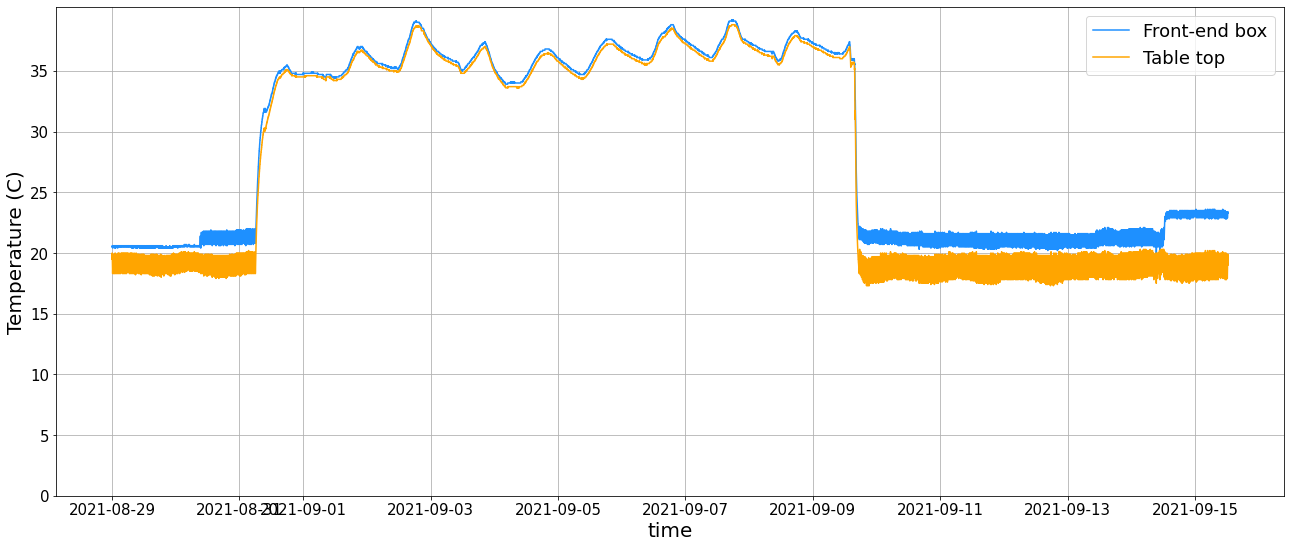

In [26]:
tempprobenames = ['tempc1','tempc2']
# dt1,dt2 = ['2021-08-23 0:00','2021-08-23 9:30']


fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(22,9), sharex=True)
colorlist = ['dodgerblue', 'orange', 'tab:green']
xmin, xmax = [42e3, 58e3]

# temperature
yscale = 1
for i,probe in enumerate(tempprobenames):
    ls = dict(linewidth=1.50,linestyle='-',color=colorlist[i],marker='o',ms=0, mfc='None', alpha=1)
    
    xvec = tempsdf[dt1:dt2]['datetime']
    yvec = yscale * tempsdf[dt1:dt2][probe]
    axs.plot(xvec, yvec,**ls)

# for i,probe in enumerate(tempprobenames):

#     xvec = temp_sec_val[i][0,:]
#     yvec = temp_sec_val[i][1,:]
#     ls = dict(linewidth=0,linestyle='-',marker='o',ms=7, alpha=1)
#     axs[0].plot(xvec, yvec,**ls)



fs = dict(color='k', fontsize=20)
plt.xlabel('time',**fs)

axs.set_ylabel('Temperature (C)', **fs)

# leglist = ['Air', 'Regen top surface', 'Front-end box air']
leglist = ['Front-end box', 'Table top']
axs.legend(leglist, fontsize=18, loc='best')

def timeplotfmt(x,pos):
    h = np.int(x/3600)
    m = np.int((x - 3600*h)/60)
    return str(f'{h:02}:{m:02}')
# axs.set_xticks(np.arange(xmin,xmax, 20*60))
# axs.xaxis.set_major_formatter(timeplotfmt )
axs.set_yticks(np.arange(0,40,5))
axs.tick_params(labelcolor='k', labelsize=15 )
axs.grid(True)
plt.show()

In [18]:

figpath = r'D:/Dropbox/RBT/4grit/laser/reports/figures/temperature-stability/'
figfn = r'line-temp-20210915.png'
fig.savefig(figpath+figfn, dpi=100, format='png', bbox_inches='tight')

## UV power

In [25]:
# uvpowerpath = r'D:/Dropbox/RBT/4grit/laser/data/uv-power/20210723/'
# uvpowerfn = r'uv-power-tstart-1222.txt'
# uvpowerpath = r'D:/Dropbox/RBT/4grit/laser/data/uv-power/20210804/'
uvpowerpath = r'D:/Dropbox/RBT/4grit/laser/data/uv-power/20210820/'
# uvpowerfn = r'uv-power-tstart-1228.txt'
# uvpowerfn = r'uv-power-tstart-1525.txt'
uvpowerfn = r'uv-power-tstart-1344.txt'

uvpowerdf = pd.read_csv(uvpowerpath+uvpowerfn, sep='\s+', names=['dt','--','ampm', 'power', 'unit'], skiprows=[0,1], parse_dates={'datetime': [0, 1,2]})
tsdate = [td.date() for td in uvpowerdf['datetime']]
tstime = [ 60**2 * td.time().hour + 60*td.time().minute + td.time().second for td in uvpowerdf['datetime']]
uvpowerdf['date'] = tsdate
uvpowerdf['time'] = tstime

# set datetime as index
uvpowerdf.set_index('datetime', drop=False, inplace=True)
# uvpowerdf = pd.read_csv(uvpowerpath+uvpowerfn, sep='\s+', skiprows=[0,1], parse_dates=[0,1])

In [26]:
uvpowerdf[dt1:dt2].describe()

,power,time
count,7199.000000,7199.000000
mean,0.015820,53254.149882
std,0.006497,2181.811155
min,-0.045286,49476.000000
25%,0.011321,51365.500000
50%,0.012307,53254.000000
75%,0.021506,55143.500000
max,0.031417,57032.000000


# IR energy 
---
from control camera

In [48]:
# irengpath = [r'D:/Dropbox/RBT/4grit/laser/data/Scarell/Energy/Camera/2021/08/04/']
irengpath = [r'D:/Dropbox/RBT/4grit/laser/data/Scarell/Energy/Camera/2021/08/20/']
fnlist = []
for outpath in irengpath:
    fnlisttemp = os.listdir(outpath)
    fnlisttemp = [ outpath+fn for fn in fnlisttemp if (('Energy' in fn) 
                                    and ('.txt' in fn)
                                    # and ('17.10.10' in fn)
                                    ) 
    ]
    fnlist += fnlisttemp

# irengfn = r'2021.07.23_14.50.30.796_Energy.txt'
from datetime import datetime
my_date_parser = lambda x: datetime.strptime(x, r"%Y.%m.%d_%H.%M.%S.%f")

irengdflist = []
for fn in fnlist:

    irengdf = pd.read_csv(fn, sep='\t', skiprows=6, names=['datetime', 'energy', 'saturated'], parse_dates=['datetime'], date_parser=my_date_parser)
    tsdate = [td.date() for td in irengdf['datetime']]
    
    tstime = [ 60**2 * td.time().hour + 60*td.time().minute + td.time().second for td in irengdf['datetime']]
    irengdf['date'] = tsdate
    irengdf['time'] = tstime
    # set datetime as index
    irengdf.set_index('datetime', drop=False, inplace=True)
    
    irengdflist.append(irengdf)



In [49]:
irengdflist

[                                       datetime     energy saturated  \
 datetime                                                               
 2021-08-20 13:10:08.255 2021-08-20 13:10:08.255   0.452009        ok   
 2021-08-20 13:10:09.255 2021-08-20 13:10:09.255   0.451771        ok   
 2021-08-20 13:10:10.254 2021-08-20 13:10:10.254   0.452344        ok   
 2021-08-20 13:10:11.255 2021-08-20 13:10:11.255   0.454666        ok   
 2021-08-20 13:10:12.255 2021-08-20 13:10:12.255   0.453429        ok   
 ...                                         ...        ...       ...   
 2021-08-20 15:56:43.431 2021-08-20 15:56:43.431  24.076700        ok   
 2021-08-20 15:56:44.430 2021-08-20 15:56:44.430  24.070400        ok   
 2021-08-20 15:56:45.436 2021-08-20 15:56:45.436  24.072100        ok   
 2021-08-20 15:56:46.431 2021-08-20 15:56:46.431  24.085500        ok   
 2021-08-20 15:56:47.431 2021-08-20 15:56:47.431  24.084700        ok   
 
                                date   time  
 da

In [50]:
for irengdf in irengdflist:
    print(irengdf[dt1:dt2].describe())

            energy          time
count  8808.000000   8808.000000
mean     23.091709  53003.500000
std       3.880690   2542.794919
min       0.445320  48600.000000
25%      23.625975  50801.750000
50%      23.816750  53003.500000
75%      23.948100  55205.250000
max      24.090700  57407.000000


# Signal processing basic
---

In [29]:
from scipy.signal import find_peaks

def calc_period(df, ind):
    tsec = df['time'].iloc[ind].to_numpy()
    dtsec = tsec[1:] - tsec[0:-1]
    return dtsec.mean()



uvpeakindex, uvpeakprop = find_peaks(1e3*uvpowerdf[dt1:dt2]['power'].to_numpy(), height=5, width=100)

uv_dtsec = calc_period(uvpowerdf, uvpeakindex)
print(f'UV mean period = {uv_dtsec/60} min')

# irpeakindex, irpeakprop = find_peaks(1e3*irengdflist[0]['energy'].to_numpy())

# tempprobenames = ['loop1','loop2','loop3']
tempprobenames = ['tempc1','tempc2']

temppeakindex = []
temp_sec_val = []
temp_dtsec = []
dfi = tempsdf[dt1:dt2]

for probe in tempprobenames:
    
    tpind, temppeakprop = find_peaks(dfi[probe].to_numpy(), height=5, width=7)
    temppeakindex.append(tpind)
    tsec = dfi['time'].iloc[tpind].to_numpy()
    
    temp_sec_val.append(np.array([tsec, temppeakprop['peak_heights']]))
    
    peri = calc_period(dfi, tpind)
    print(probe)
    print(f'mean period = {peri/60} min')
    temp_dtsec.append( peri )

temp_sec_val[0].shape


UV mean period = 28.183333333333334 min
tempc1
mean period = 150.0 min
tempc2
mean period = 91.5 min


(2, 2)

In [30]:

uvpowerdf[dt1:dt2]['power'].describe()

count    7199.000000
mean        0.015820
std         0.006497
min        -0.045286
25%         0.011321
50%         0.012307
75%         0.021506
max         0.031417
Name: power, dtype: float64

In [126]:
40.6-27.9

12.700000000000003

In [125]:
40.4-19.7

20.7

# plot
---

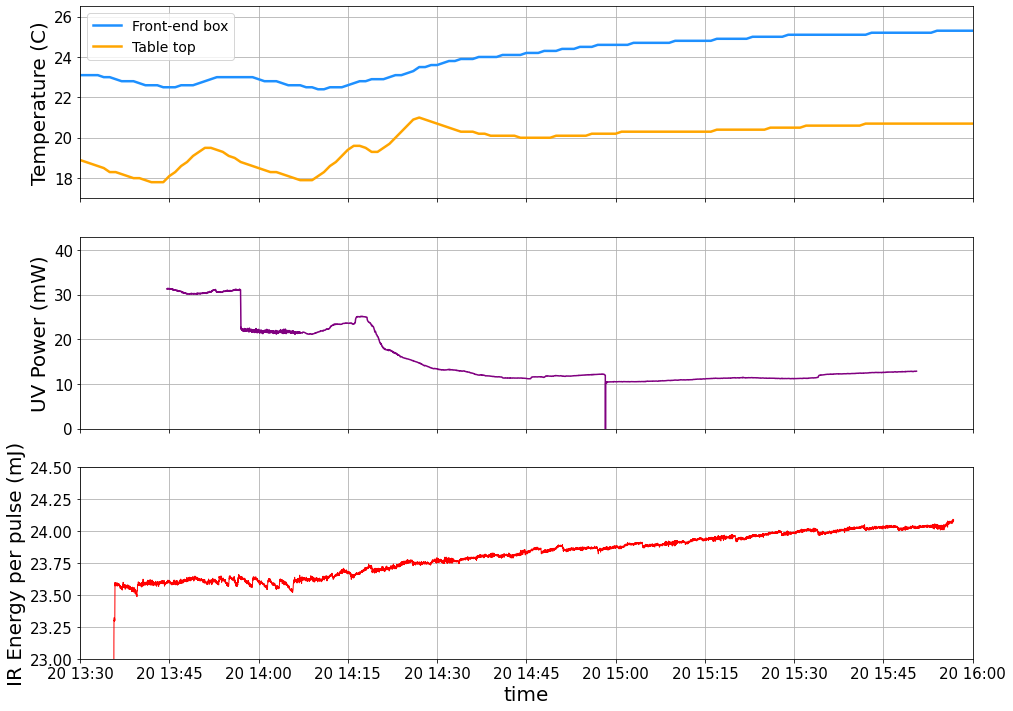

In [55]:
zoombool = True

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(16,12), sharex=True)
colorlist = ['dodgerblue', 'orange', 'tab:green']
xmin, xmax = [42e3, 58e3]
# temperature

yscale = 1
for i,probe in enumerate(tempprobenames):
    ls = dict(linewidth=2.5,linestyle='-',color=colorlist[i],marker='o',ms=0, mfc='None', alpha=1)
    
    xvec = tempsdf[dt1:dt2]['datetime']
    yvec = yscale * tempsdf[dt1:dt2][probe]
    axs[0].plot(xvec, yvec,**ls)

# for i,probe in enumerate(tempprobenames):

#     xvec = temp_sec_val[i][0,:]
#     yvec = temp_sec_val[i][1,:]
#     ls = dict(linewidth=0,linestyle='-',marker='o',ms=7, alpha=1)
#     axs[0].plot(xvec, yvec,**ls)


# UV power
ls = dict(linewidth=1.5,linestyle='-',color=colorlist[i],marker='o',ms=0, mfc='None', alpha=1)
ls['color'] = 'purple'

xvec = uvpowerdf[dt1:dt2]['datetime']
yscale = 1e3
yvec = yscale * uvpowerdf[dt1:dt2]['power']
axs[1].plot(xvec, yvec,**ls)

# xvec = uvpowerdf['time'].iloc[uvpeakindex]
# yvec = uvpeakprop['peak_heights']
# ls = dict(linewidth=0,linestyle='-',color='purple', marker='o',ms=7, alpha=1)
# axs[1].plot(xvec,yvec, **ls)

# IR energy
ls = dict(linewidth=1.0,linestyle='-',marker='o',ms=0, mfc='None', alpha=1)
ls['color'] = 'red'
for irengdf in irengdflist:
    xvec = irengdf[dt1:dt2]['datetime']
    yscale = 1
    yvec = yscale * irengdf[dt1:dt2]['energy']
    axs[2].plot(xvec, yvec, **ls)

fs = dict(color='k', fontsize=20)
plt.xlabel('time',**fs)

axs[0].set_ylabel('Temperature (C)', **fs)
axs[1].set_ylabel('UV Power (mW)', **fs)
axs[2].set_ylabel('IR Energy per pulse (mJ)', **fs)

# leglist = ['Air', 'Regen top surface', 'Front-end box air']
leglist = ['Front-end box', 'Table top']
axs[0].legend(leglist, fontsize=14,loc='best')

if zoombool:
    # axs[0].set_ylim([ 16,23.5])
    # axs[1].set_ylim([ 20,42])
    # axs[2].set_ylim([ 23.4,23.8])
    axs[0].set_ylim([ 17,26.5])
    axs[1].set_ylim([ 0,43])
    axs[2].set_ylim([ 23,24.5])
else:
    axs[0].set_ylim([ 0,30])
    axs[1].set_ylim([ 0,50])
    axs[2].set_ylim([ 0,30])

import datetime
# axs[0].set_xlim( [ datetime.datetime(2021,8,4,hour=12,minute=30), datetime.datetime(2021,8,4,hour=14,minute=30) ] )
# axs[0].set_xlim( [ datetime.datetime(2021,8,4,hour=15,minute=55), datetime.datetime(2021,8,4,hour=16,minute=25) ] )
axs[0].set_xlim( [ datetime.datetime(2021,8,20,hour=13,minute=30), datetime.datetime(2021,8,20,hour=16,minute=00) ] )

# def timeplotfmt(x,pos):
#     h = np.int(x/3600)
#     m = np.int((x - 3600*h)/60)
#     return str(f'{h:02}:{m:02}')
# axs[2].set_xticks(np.arange(xmin,xmax, 20*60))
# axs[2].xaxis.set_major_formatter(timeplotfmt )

for ax in axs:
    ax.tick_params(labelcolor='k', labelsize=15 )
    ax.grid(True)
plt.show()

In [56]:
figpath = r'D:/Dropbox/RBT/4grit/laser/reports/figures/temperature-stability/'
figfn = r'linezoomzoom-temp-uvpower-irenergy-900ns-20210823.png'
fig.savefig(figpath+figfn, dpi=100, format='png', bbox_inches='tight')

In [65]:
tempsdf.set_index('datetime')['2021-08-04 12:30':'2021-08-04 13:30']

,tempc1,relhumid1,date,time,tempc2,relhumid2,time2
datetime,,,,,,,
2021-08-04 12:30:00,21.5,41.7,2021-08-04,45000.0,18.7,49.3,45000
2021-08-04 12:31:00,21.6,41.7,2021-08-04,45060.0,19.1,48.8,45060
2021-08-04 12:32:00,21.9,41.8,2021-08-04,45120.0,19.4,48.3,45120
2021-08-04 12:33:00,22.1,43.0,2021-08-04,45180.0,19.6,51.4,45180
2021-08-04 12:34:00,22.1,42.5,2021-08-04,45240.0,19.6,48.8,45240
...,...,...,...,...,...,...,...
2021-08-04 13:26:00,22.9,38.7,2021-08-04,48360.0,18.8,47.0,48360
2021-08-04 13:27:00,22.8,38.4,2021-08-04,48420.0,18.6,47.1,48420
2021-08-04 13:28:00,22.8,38.2,2021-08-04,48480.0,18.3,47.4,48480


In [318]:
tempdtsec/60

array([26.75, 26.75, 26.75])

In [1]:
cl.laser.zrayleigh(10e-6,1030e-9)

NameError: name 'cl' is not defined